In [1]:
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from IPython.display import display
import sys
from statistics import mean
from timeit import default_timer as timer


# * Windows versus mac.
#folder = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/2019/08/09/'
folder = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample2\2019\08\09' 


## http://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
# You can copy the function from there and save it to your computer.
sys.path.append(r'C:\Users\vhorowit\Documents')
sys.path.append(r'C:\Users\vhorowit\Documents\detect_peaks.py')
import detect_peaks
from detect_peaks import detect_peaks

#sns.set(style='ticks') # makes longer tick marks
sns.set_context('poster') # makes text larger

# Create a listwrap that wraps around the list 
# This is what I need for pcolormesh.
def listwrap(currentlist):
    # Ideally the dimensions of X and Y should be one greater than those of C; 
    # if the dimensions are the same, then the last row and column of C will be ignored.
    listwrap = [0] * (len(currentlist)+1)
    for i in range(len(currentlist)):
        try:
            listwrap[i+1] = ((currentlist[i]+currentlist[i+1])/2)
        except IndexError:
            pass
    topstep = listwrap[2]-listwrap[1]
    listwrap[0]=listwrap[1]-topstep
    botstep = listwrap[-2]-listwrap[-3]
    listwrap[-1]=listwrap[-2]+botstep
    return listwrap

# df is a pandas dataframe
def myheatmap(df, colorbarlabel=None, **kwargs):
    plt.pcolormesh( listwrap(df.columns),listwrap(df.index), df, **kwargs)
    plt.xlabel(df.columns.name)
    plt.ylabel(df.index.name)
    cbar = plt.colorbar(drawedges=False)
    if colorbarlabel:
        cbar.set_label(colorbarlabel)
    return plt.gca()
 

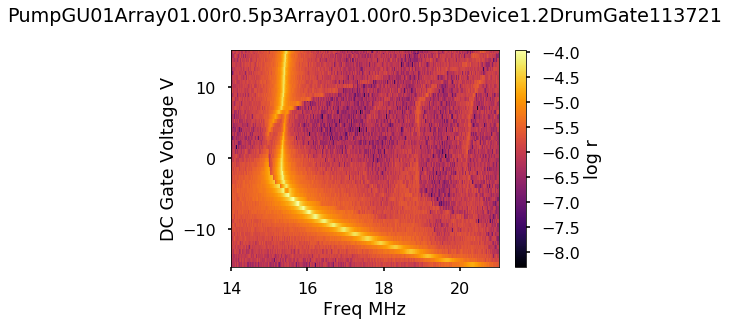

In [2]:
file = 'PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2DrumGate113721' 
path = os.path.join(folder,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df)  

df['rlog'] = np.log10(df.r) 
df['Freq MHz']=(df.frequency)/10**6
df['Freq MHz']= df['Freq MHz'].round(2)
df['DC Gate Voltage V'] = df['Keithley Voltage'].round(2)
p = df.pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'rlog').sort_index(axis = 0, ascending = False) 
#sns.heatmap(p)

myheatmap(p,'log r', cmap = 'inferno')
plt.title(file + '\n');

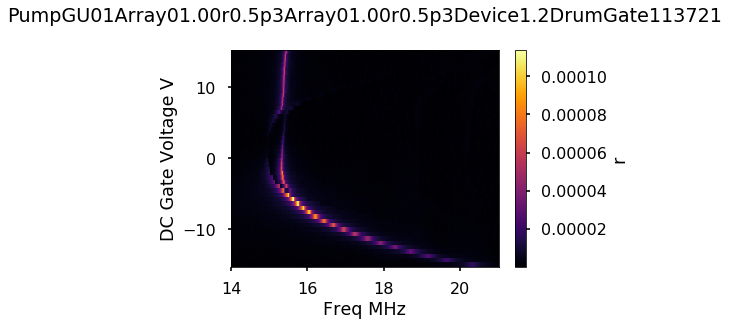

In [3]:
# This is the same heatmap as shown above except it shows r instead of log(r)

p2 = df.pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False) 
myheatmap(p2, 'r', cmap='inferno')
plt.title(file + '\n');

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


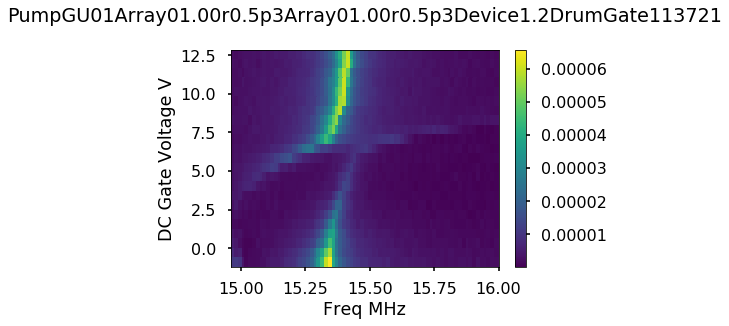

In [4]:
lf = df['Freq MHz'] > 14.95 
hf = df['Freq MHz'] < 16 
lv = df['DC Gate Voltage V'] > -1
hv = df['DC Gate Voltage V'] < 13.1
n = df[lf][hf][lv][hv].pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False)
myheatmap(n)
plt.title(file + '\n');

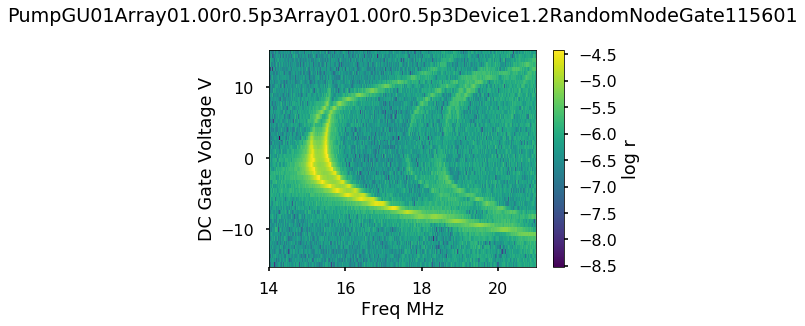

In [5]:
file = 'PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2RandomNodeGate115601'
path = os.path.join(folder,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df)

df['rlog'] = np.log10(df.r) 
df['Freq MHz']=(df.frequency)/10**6
df['Freq MHz']= df['Freq MHz'].round(5)
df['DC Gate Voltage V'] = df['Keithley Voltage'].round(5)
p = df.pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'rlog').sort_index(axis = 0, ascending = False) 
myheatmap(p, 'log r')
plt.title(file + '\n');

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


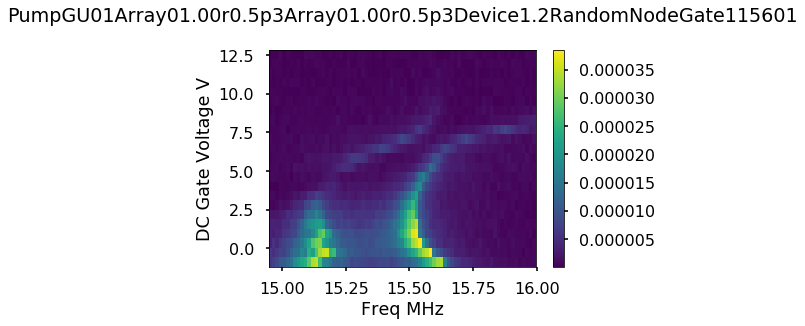

In [6]:
lf = df['Freq MHz'] > 14.95 
hf = df['Freq MHz'] < 16 
lv = df['DC Gate Voltage V'] > -1
hv = df['DC Gate Voltage V'] < 13.1
n = df[lf][hf][lv][hv].pivot_table(index = 'DC Gate Voltage V', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False)
myheatmap(n)
plt.title(file + '\n');

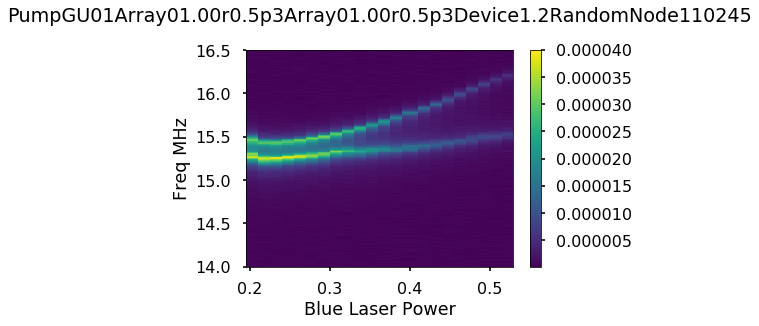

In [7]:
file = 'PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2RandomNode110245'
path = os.path.join(folder,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#df.head()

df['rlog'] = np.log10(df.r) 
df['Freq MHz']=(df.frequency)/10**6
df['Freq MHz']= df['Freq MHz'].round(2)
df['Blue Laser Power'] = df['DC Offset'].round(2)
p = df.pivot_table(index = 'Blue Laser Power', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False) 
#p.columns_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 16)

myheatmap((p.iloc[:-1]).transpose())
plt.title(file + '\n');

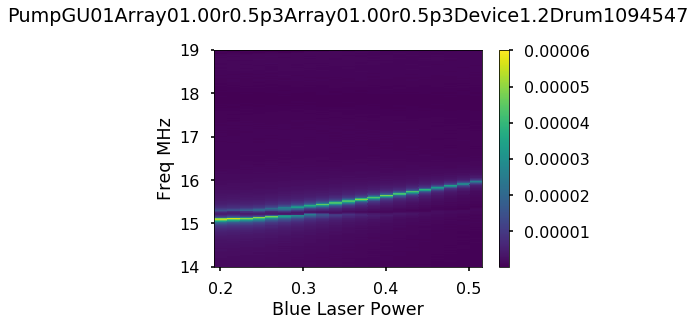

In [8]:
file = 'PumpGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum1094547'
path = os.path.join(folder,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df)

## warning: round(2) does not create evenly spaced frequency values.
df['rlog'] = np.log10(df.r) 
df['Freq MHz']=(df.frequency)/10**6
df['Freq MHz']= df['Freq MHz'].round(9)
df['Blue Laser Power'] = df['DC Offset'].round(9)
p = df.pivot_table(index = 'Blue Laser Power', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False) 
myheatmap((p.iloc[:-1]).transpose()) # cutting out last laser power because it is incomplete
plt.title(file + '\n');

0


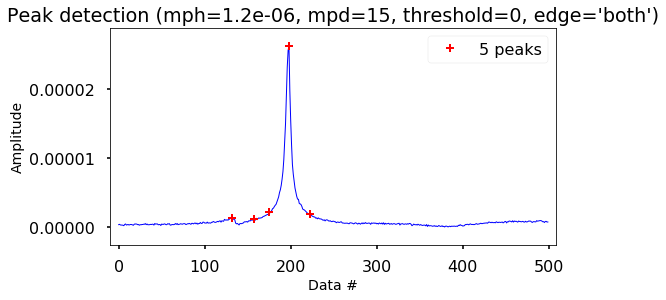

0.507692308
[132, 198]
1


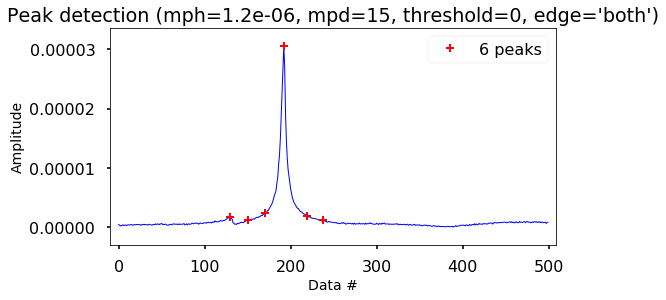

0.492307692
[130, 192]
2


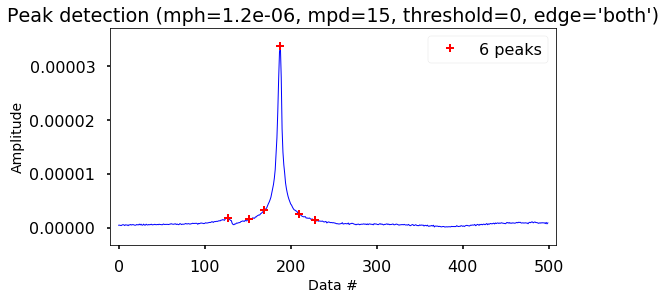

0.476923077
[127, 188]
3


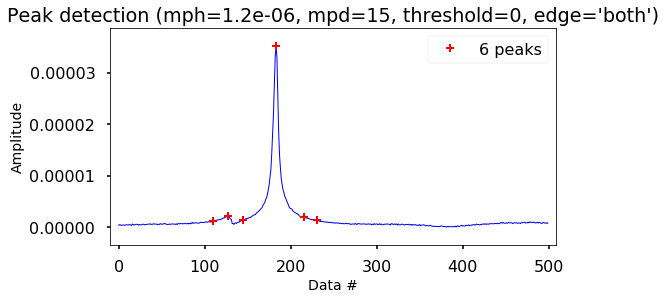

0.461538462
[127, 183]
4


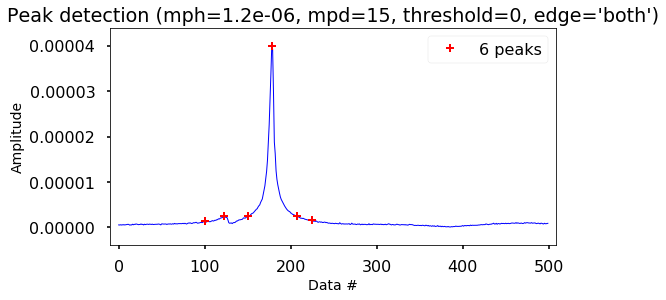

0.446153846
[123, 178]
5


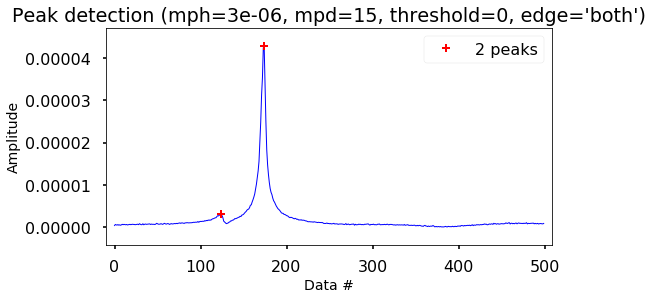

0.430769231
[124, 174]
6


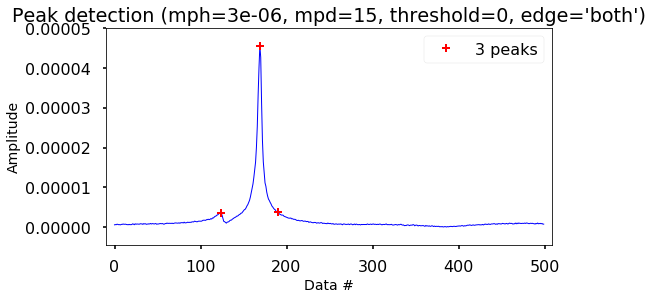

0.415384615
[124, 169]
7


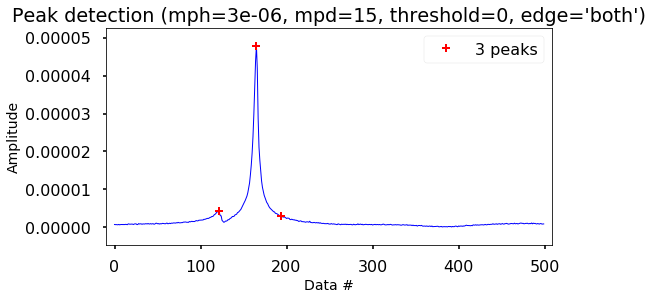

0.4
[121, 165]
8


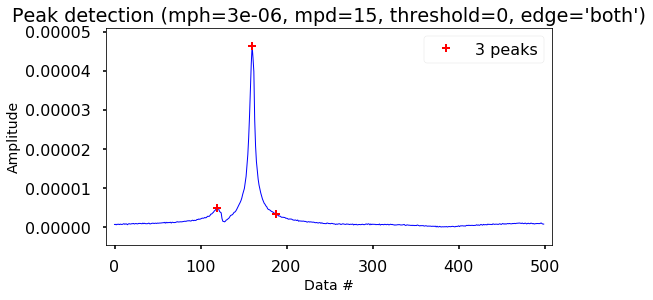

0.384615385
[119, 160]
9


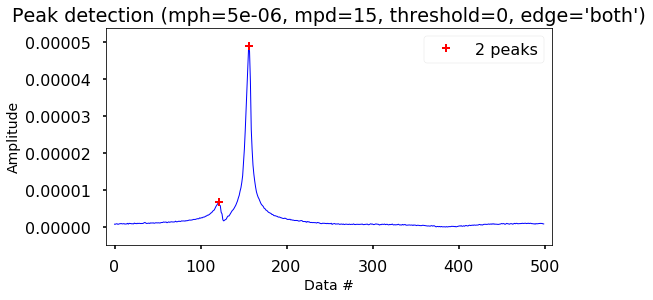

0.369230769
[121, 156]
10


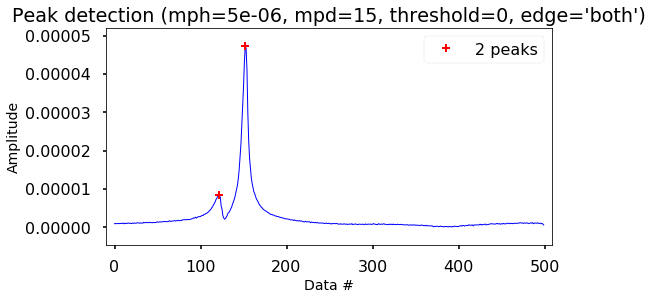

0.353846154
[121, 152]
11


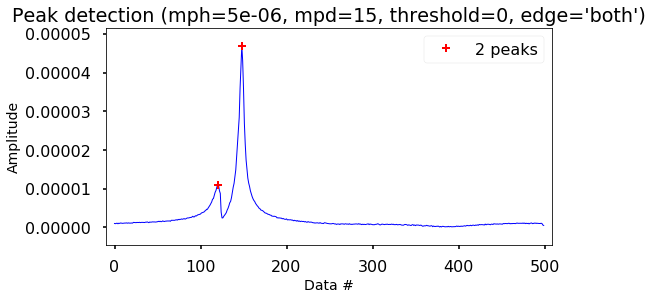

0.338461538
[120, 148]
12


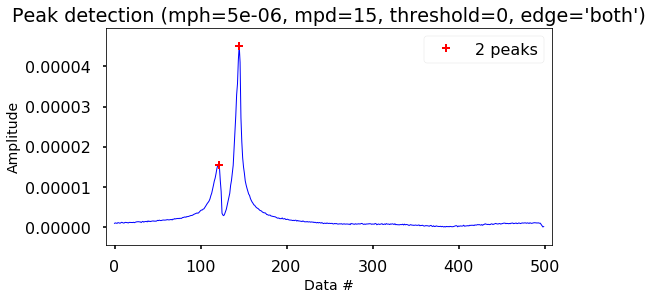

0.323076923
[121, 145]
13


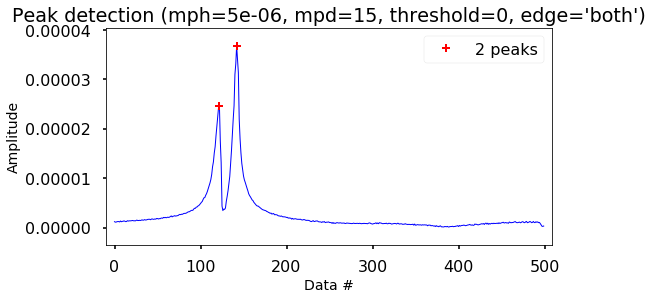

0.307692308
[122, 142]
14


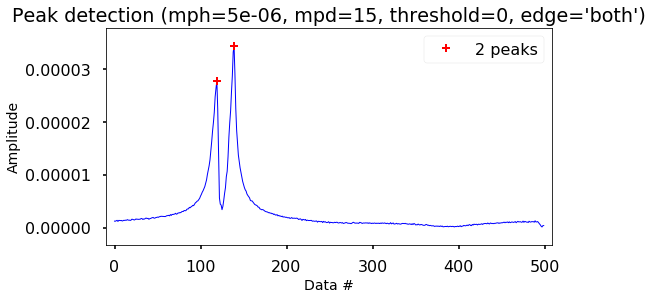

0.292307692
[119, 139]
15


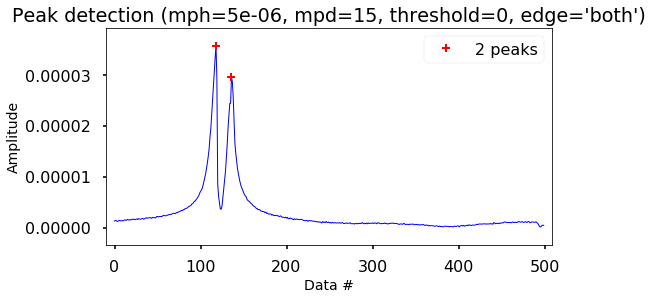

0.276923077
[118, 136]
16


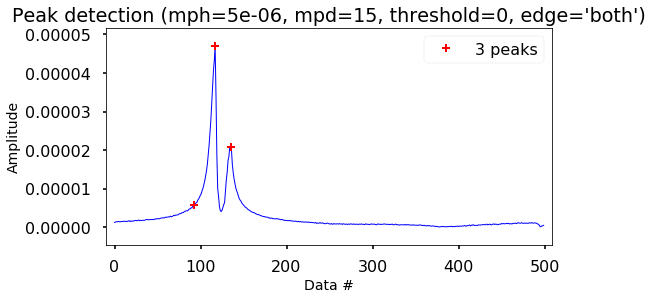

0.261538462
[117, 135]
17


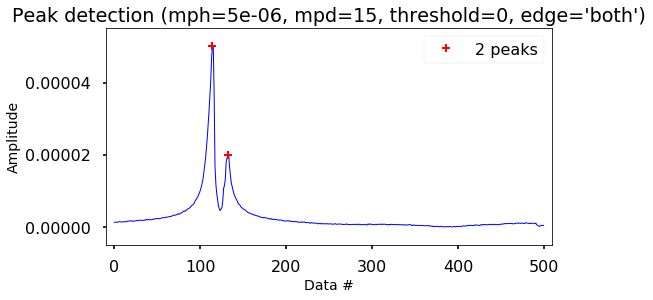

0.246153846
[114, 132]
18


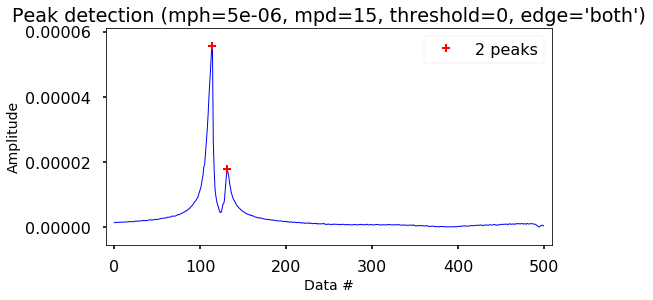

0.230769231
[114, 131]
19


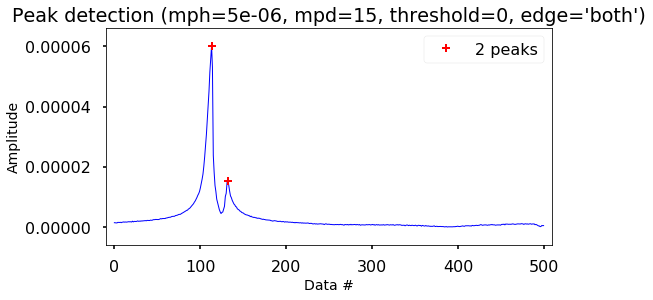

0.215384615
[113, 132]
20


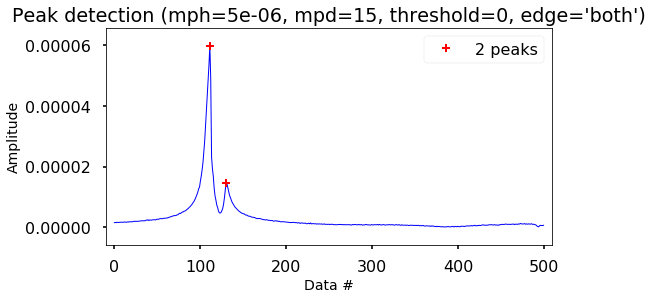

0.2
[111, 130]
21


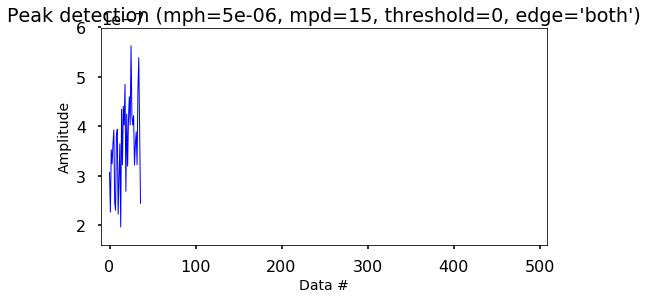

[Float64Index([15.322645291, 15.983967936], dtype='float64', name='Freq MHz'), Float64Index([15.30260521, 15.923847695], dtype='float64', name='Freq MHz'), Float64Index([15.27254509, 15.883767535], dtype='float64', name='Freq MHz'), Float64Index([15.27254509, 15.833667335], dtype='float64', name='Freq MHz'), Float64Index([15.23246493, 15.783567134], dtype='float64', name='Freq MHz'), Float64Index([15.24248497, 15.743486974], dtype='float64', name='Freq MHz'), Float64Index([15.24248497, 15.693386774], dtype='float64', name='Freq MHz'), Float64Index([15.21242485, 15.653306613], dtype='float64', name='Freq MHz'), Float64Index([15.19238477, 15.603206413], dtype='float64', name='Freq MHz'), Float64Index([15.21242485, 15.563126253], dtype='float64', name='Freq MHz'), Float64Index([15.21242485, 15.523046092], dtype='float64', name='Freq MHz'), Float64Index([15.20240481, 15.482965932], dtype='float64', name='Freq MHz'), Float64Index([15.21242485, 15.452905812], dtype='float64', name='Freq MHz'

,peak1 freq [MHz],peak2 freq [MHz]
Blue Laser Power,,
0.507692,15.322645,15.983968
0.492308,15.302605,15.923848
0.476923,15.272545,15.883768
0.461538,15.272545,15.833667
0.446154,15.232465,15.783567
0.430769,15.242485,15.743487
0.415385,15.242485,15.693387
0.400000,15.212425,15.653307
0.384615,15.192385,15.603206


In [9]:
freqlistp = []
peaksintp = []


## I tweaked this a lot for this particular dataset
for i in range(len(p)):
    print(i)
    if i < 5:
        mph = 1.2e-6
    elif i < 9:
        mph = 3e-6
    else: 
        mph = 5e-6
    res= detect_peaks(p.iloc[i], 
             mph=mph, 
           #  threshold=1e-8,
             mpd=15,
             edge = 'both',
             show=True)
    
    ## I manually picked out the correct peaks
    if i <= 2:
        res = list(res[j] for j in [0,3])
    elif i <= 4:
        res = list(res[j] for j in [1,3] )
    elif i == 16:
        res = list(res[j] for j in [1,2])
    elif i ==21:
        continue
    else:
        res = list(res[j] for j in [0,1])
        
    print(p.iloc[i].name)
    print(res)
    freqlistp.append(p.columns[res])
    peaksintp.append(res)
    #print(peaksintp[i])
    
print(freqlistp)
print(peaksintp)

peakfreqsp = pd.DataFrame(freqlistp, index = p.index[:-1], columns=["peak1 freq [MHz]", "peak2 freq [MHz]"])
peakfreqsp

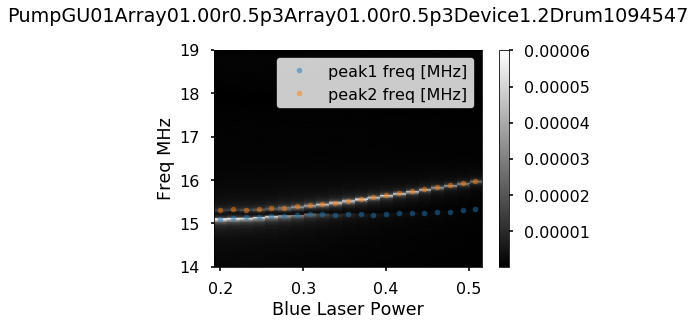

In [10]:
ax = myheatmap((p.iloc[:-1]).transpose(), cmap = 'gray') # cutting out last row because it is incomplete
peakfreqsp.plot(ax=ax, marker = '.', alpha = .5, linestyle= 'None', legend=True)

plt.title(file + '\n');

In [11]:
from matplotlib.mlab import frange
from numpy import sqrt

def lowerantifn(x,m1,m2,k,k1):
    k2 = k1+x;
    return sqrt(x/m2 + k/m2 + k1/m2 + k/m1 + k1/m1 - 
                      sqrt(-4*(k*k1 + k*k2 + k1*k2)*m1*m2 + (-k*m1 - k2*m1 - k*m2 - k1*m2)**2)
                      /(m1*m2))/sqrt(2)
def upperantifn(x,m1,m2,k,k1):
    k2 = k1+x;
    return sqrt(x/m2 + k/m2 + k1/m2 + k/m1 + k1/m1 + 
                      sqrt(-4*(k*k1 + k*k2 + k1*k2)*m1*m2 + (-k*m1 - k2*m1 - k*m2 - k1*m2)**2)
                      /(m1*m2))/sqrt(2)
def middle1(x, m1,m2,k,k1):
    return sqrt(x/m2 + k/m2 + k1/m2 + k/m1 + k1/m1)/sqrt(2)

"""
## Manually choose test parameters; these will be the starting points for the fit.
k1 = 1.3   # lower is curvier, higher is larger values and straighter. higher also moves the crossing to the right.
m1 = .0057    # lower moves the crossing to the right, higher moves the crossing to the left
m2 = .007    # lower moves the crossing to the left, higher moves the crossing to the right
            # if both masses get lower, the crossing gets higher
k = 0.01;     # higher makes the anti-crossing wider, lower makes the anti-crossing closer.


#dk = frange(-1,1 , .1)
#dk = peakfreqsp.index.values
dk = frange(peakfreqsp.index.values.min(), peakfreqsp.index.values.max(), .001)
#dk = frange(-10, 1000, .001)


## Plot the guesses to find a good starting guess
peakfreqsp.plot( marker = '.', linestyle = 'None', legend=None)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1))
plt.plot(dk,upperantifn(dk, m1,m2,k,k1))
plt.plot(dk,middle1(dk, m1,m2,k,k1))


del m1,m2,k,k1,dk
"""

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: numpy.arange


In [12]:
from lmfit import Model
from lmfit import minimize
import lmfit
print(lmfit.__version__)

0.9.14


In [13]:
def anticrossingresidual(params1, x, dat1, dat2):
    m1 = params1['m1']
    m2 = params1['m2']
    k = params1['k']
    k1 = params1['k1']

    model1 = upperantifn(x, m1,m2,k,k1)
    model2 = lowerantifn(x, m1,m2,k,k1)
    
    resid1 = dat1 - model1
    resid2 = dat2 - model2
    return np.concatenate((resid1, resid2))

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: numpy.arange


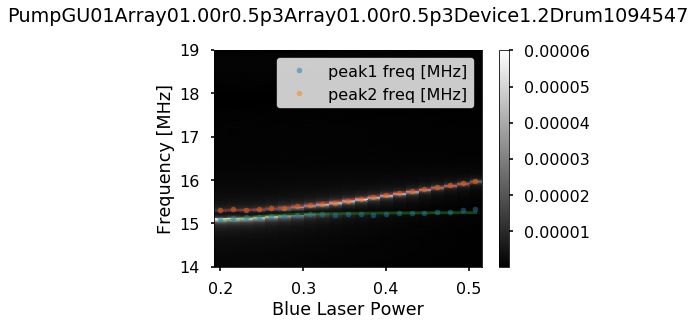

<Figure size 432x288 with 0 Axes>

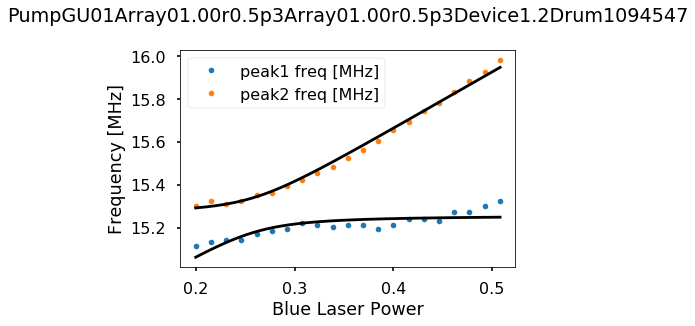

In [14]:


#upperantim = Model(upperantifn)
#lowerantim = Model(lowerantifn)

# input guesses for the fitting parameters
params1 = lmfit.Parameters()
params1.add('k1', value=1.3, vary=True)
params1.add('m1', value=.0057, vary=True) # should maybe have max 1, but seems to work better without.
params1.add('m2', value=.007 , vary=True)
params1.add('k', value=0.01, vary=True)

## plot the data
ax = myheatmap((p.iloc[:-1]).transpose(), cmap = 'gray') # cutting out last row because it is incomplete
peakfreqsp.plot(ax=ax, marker = '.', alpha = .5, linestyle= 'None', legend=True)
plt.title(file + '\n');

## data to be fit
dat1=peakfreqsp.iloc[:,1].values
dat2=peakfreqsp.iloc[:,0].values
x=peakfreqsp.index.values

## perform the fit
out = minimize(anticrossingresidual, params1, args=(x, dat1, dat2))
display(out) # display all the results

## Plot the fitting result.
dk = frange(peakfreqsp.index.values.min(), peakfreqsp.index.values.max(), .001)
# test parameters
k1 = out.params['k1'].value   # lower is curvier, higher is larger values and straighter. higher also moves the crossing to the right.
m1 = out.params['m1'].value    # lower moves the crossing to the right, higher moves the crossing to the left
m2 = out.params['m2'].value    # lower moves the crossing to the left, higher moves the crossing to the right
            # if both masses get lower, the crossing gets higher
k = out.params['k'].value;     # higher makes the anti-crossing wider, lower makes the anti-crossing closer.

## display the results
#display(out.params)

#peakfreqsp.plot( marker = '.', linestyle = 'None', legend=None)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1), alpha=.4)
plt.plot(dk,upperantifn(dk, m1,m2,k,k1), alpha=.4)
#plt.plot(dk,middle1(dk, m1,m2,k,k1))

## second plot without heatmap
plt.figure();
peakfreqsp.plot( marker = '.', linestyle= 'None', legend=True)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n')
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1), 'k')
plt.plot(dk,upperantifn(dk, m1,m2,k,k1), 'k')


#del m1,m2,k,k1,dk

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


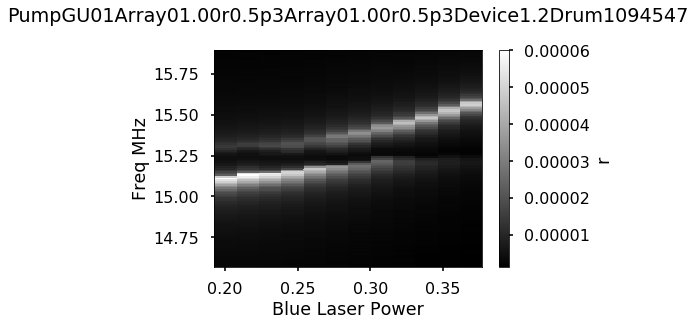

In [15]:
lf = df['Freq MHz'] > 14.57 
hf = df['Freq MHz'] < 15.9 
lv = df['Blue Laser Power'] > 0.1
hv = df['Blue Laser Power'] < 0.38
n = df[lf][hf][lv][hv].pivot_table(index = 'Blue Laser Power', columns = 'Freq MHz', values = 'r').sort_index(axis = 0, ascending = False)
myheatmap(n.transpose(), cmap = 'gray', colorbarlabel='r')
plt.title(file + '\n');

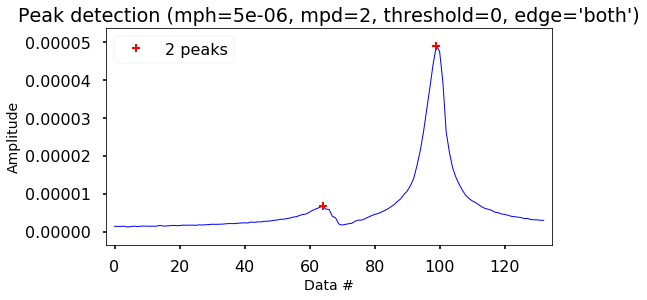

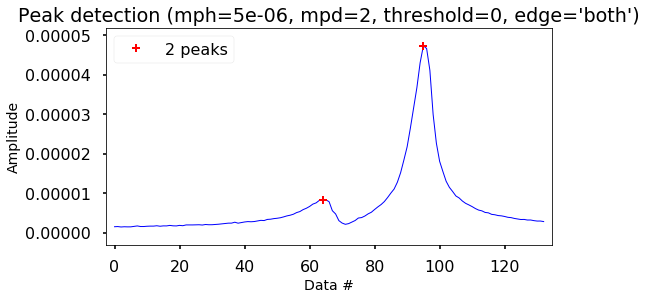

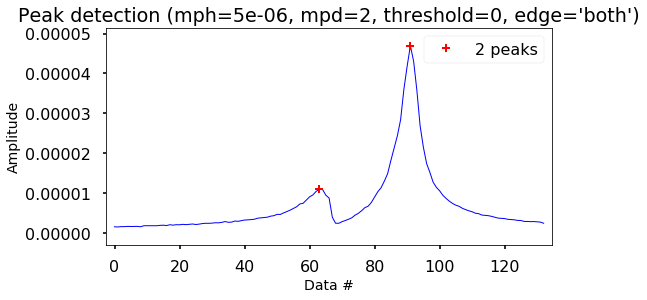

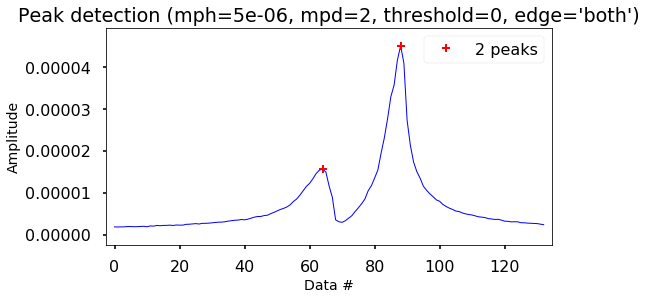

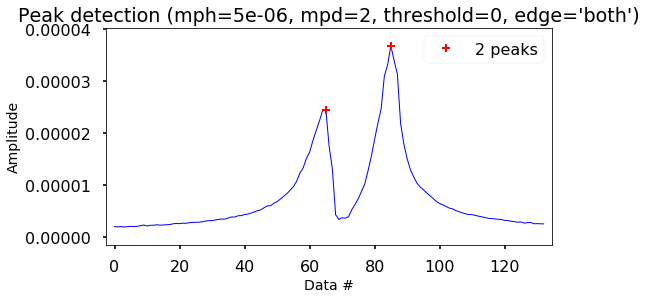

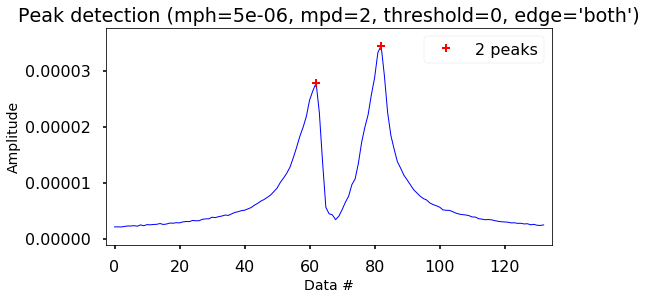

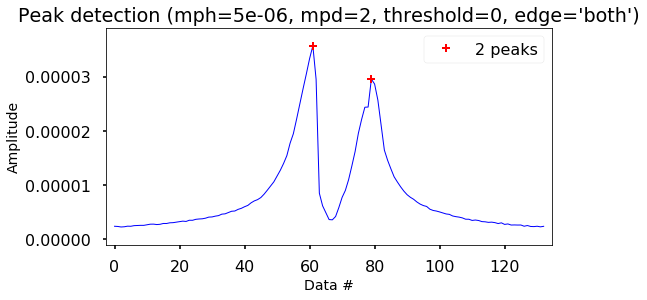

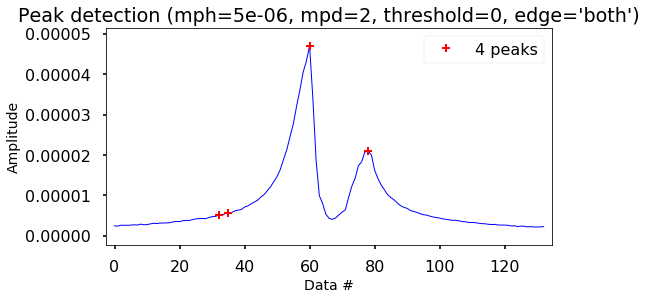

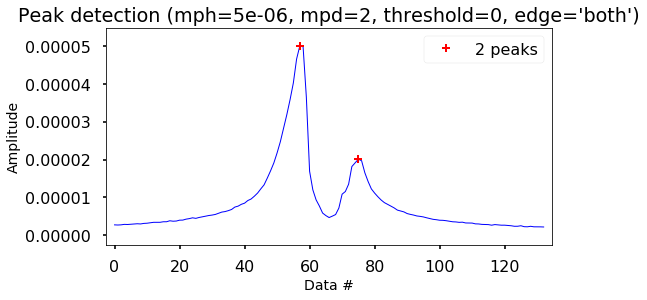

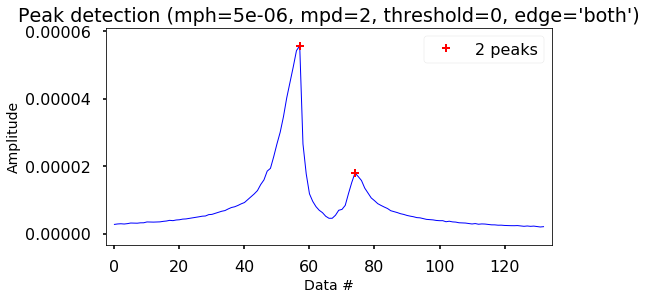

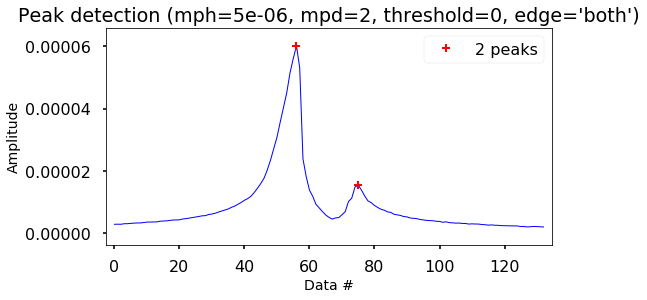

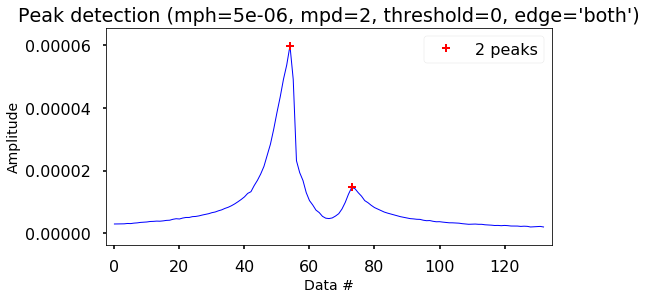

,peak1 freq [MHz],peak2 freq [MHz]
Blue Laser Power,,
0.369231,15.212425,15.563126
0.353846,15.212425,15.523046
0.338462,15.202405,15.482966
0.323077,15.212425,15.452906
0.307692,15.222445,15.422846
0.292308,15.192385,15.392786
0.276923,15.182365,15.362725
0.261538,15.172345,15.352705
0.246154,15.142285,15.322645


In [16]:

# initialize peaks list
peaksint = []
freqlist = []

for i in range(len(n)):
    res = detect_peaks(n.iloc[i], 
             mph=5e-6, 
           #  threshold=1e-8,
             mpd=2,
             edge = 'both',
             show=True)
    #print(res)
    freqlist.append(n.columns[res[-2:]])
    # shorten results to just 2 peaks
    peaksint.append(res[-2:])
    #print(peaksint[i])
    
#display(peaksint)

peakfreqsn = pd.DataFrame(freqlist, index = n.index, columns=["peak1 freq [MHz]", "peak2 freq [MHz]"])
peakfreqsn


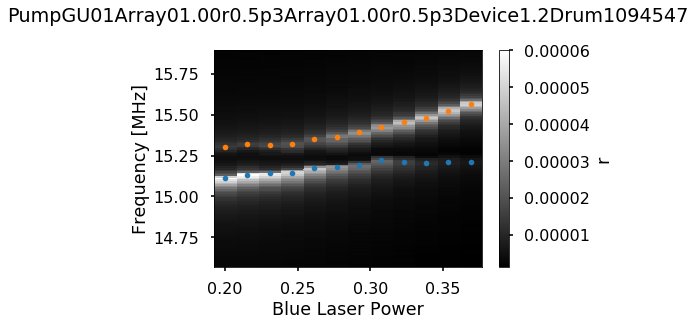

In [17]:
# To change the colors in the pcolormesh, add the pcolormesh argument: cmap = cmap
#cmap = sns.cubehelix_palette(n_colors = 1, start=0, rot=1, light=1, as_cmap=True)
#cmap = sns.cubehelix_palette( light=1, as_cmap=True)
#cmap = sns.color_palette("Grey", as_cmap=True)

ax = myheatmap(n.transpose(), 'r', cmap='gray')
peakfreqsn.plot(ax=ax, marker = '.', linestyle='None', legend=False)
plt.ylabel("Frequency [MHz]");
plt.title(file + '\n');

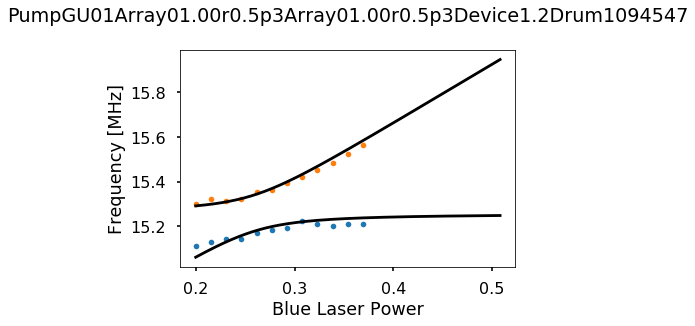

In [18]:
peakfreqsn.plot(marker = '.', linestyle='None', legend=False)
plt.ylabel("Frequency [MHz]")
plt.title(file + '\n');

## I didn't re-fit to this specific data; I already fit to the larger dataset.
plt.plot(dk,lowerantifn(dk, m1,m2,k,k1), 'k')
plt.plot(dk,upperantifn(dk, m1,m2,k,k1), 'k')